In [16]:
#from pyefd import elliptic_fourier_descriptors
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import cv2
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize

from scipy.spatial import KDTree

import sys
sys.path.append("..")

from utils import rasterize

In [17]:
# loading data
dfs = [[] for _ in range(10)]
for i in range(10):
    for k in range(100):
        df = pd.read_csv(f"../training_data/stroke_{i}_{k+1:04}.csv", header=None, usecols=[0, 1])
        df = (df - df.mean()) / df.std()
        # df = (df-df.min())/(df.max()-df.min())
        dfs[i].append(df)

In [18]:
# function rasterizes numbers from dataframe in one image to get an averaged image
def rasterize_number(df, size, thickness=5):
    tmp = np.zeros((size, size))
    pts = df[[0,1]] * size
    pts = df[[0,1]] * size/6 + size/2
    pts = pts.to_numpy().astype(np.int32)

    # draw line from each point to the next one except last
    for j in range(len(pts)-1):
        tmp = cv2.line(tmp, pts[j], pts[j+1], 1, thickness)
    tmp  = cv2.flip(tmp, 0)

    return tmp

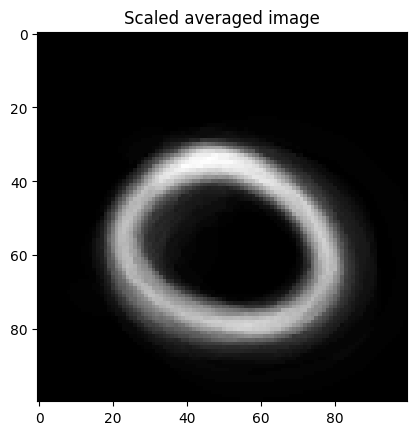

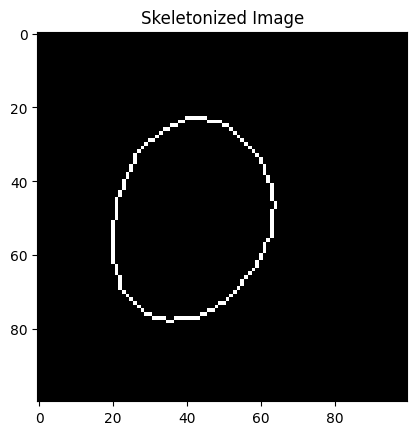

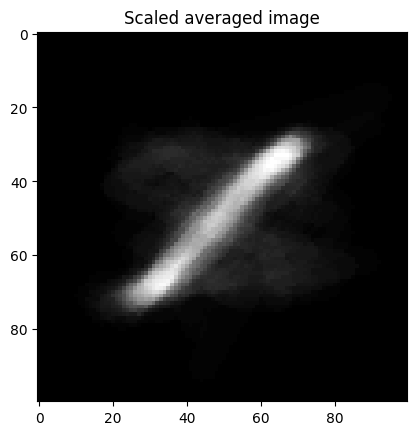

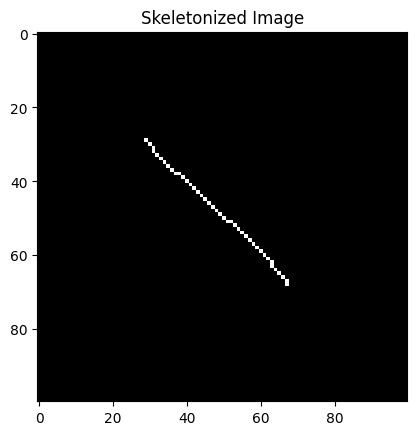

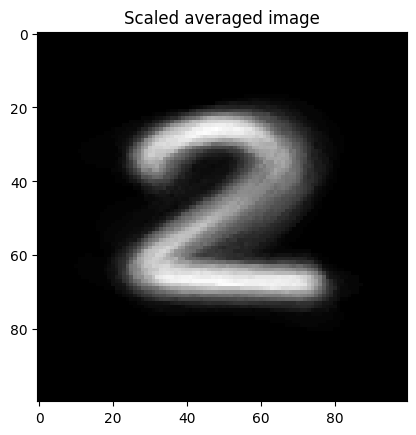

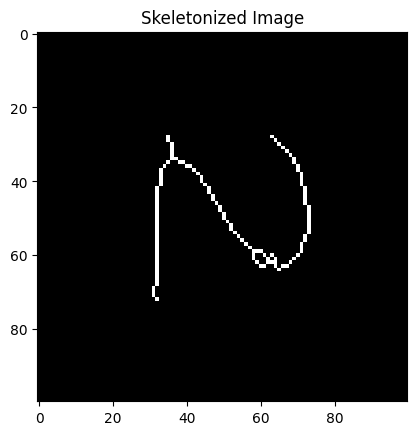

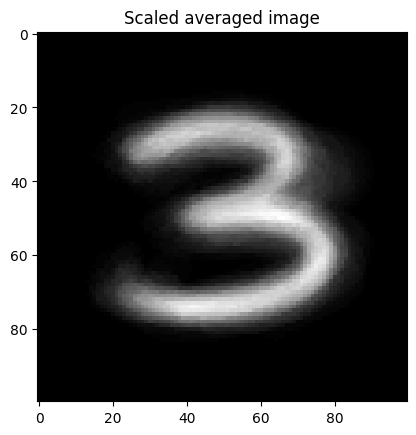

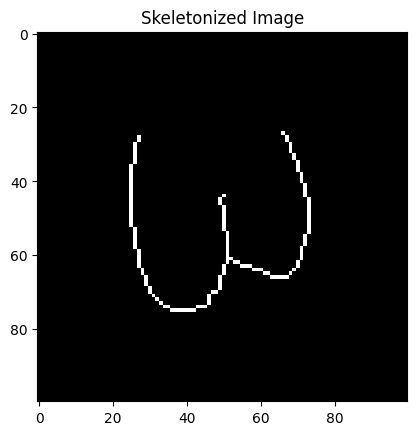

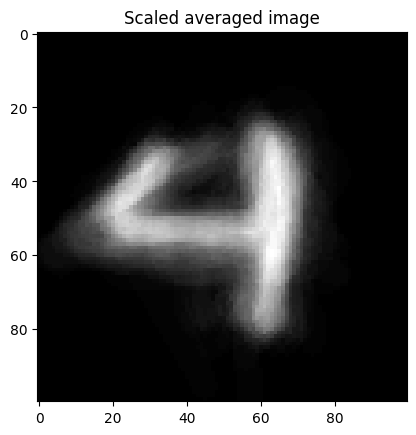

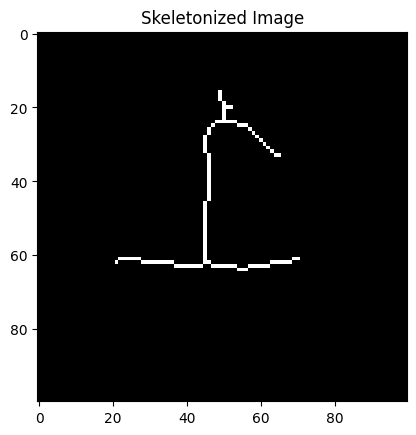

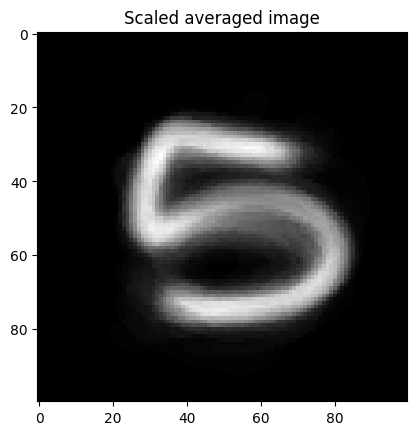

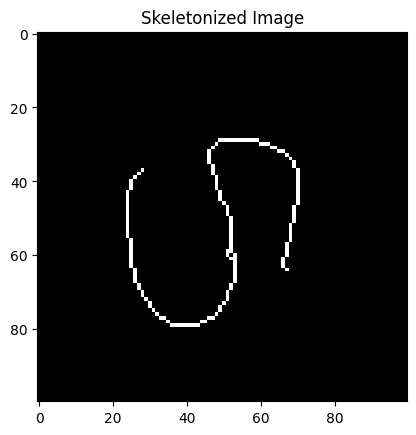

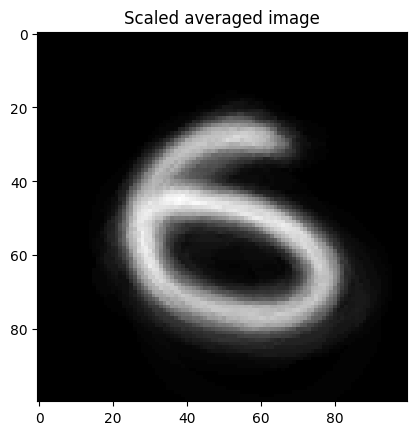

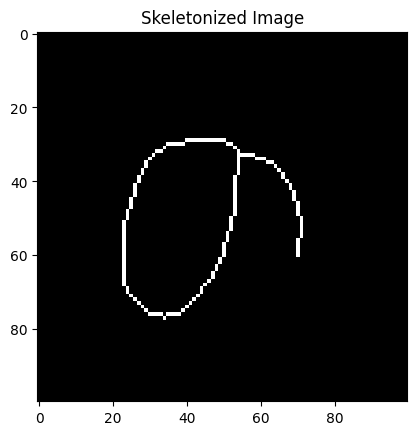

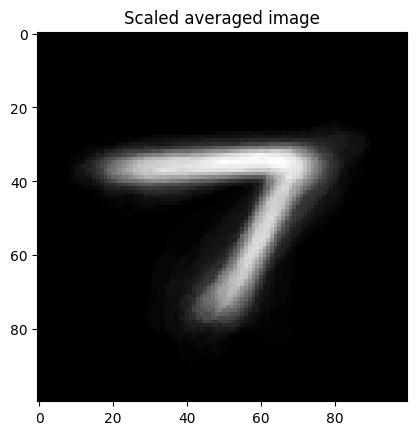

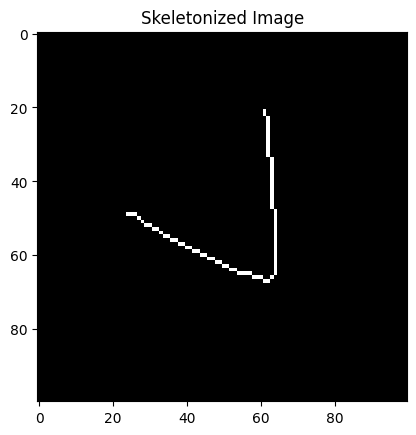

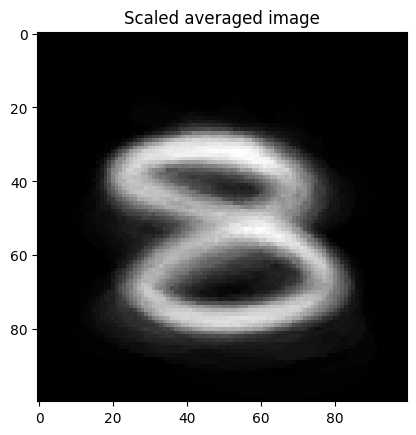

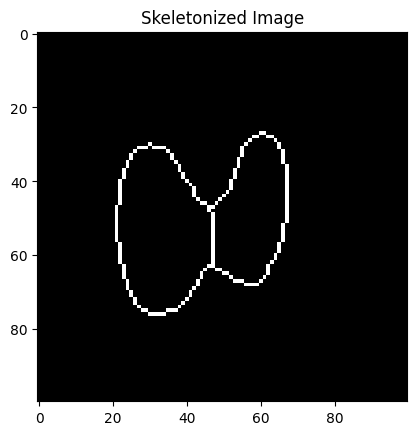

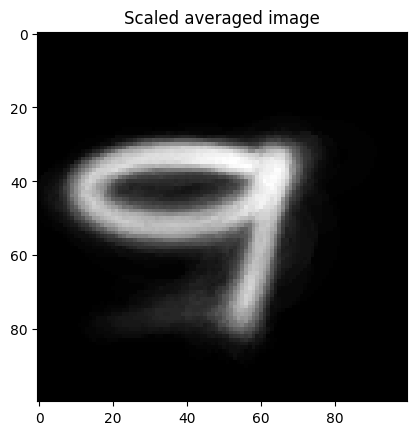

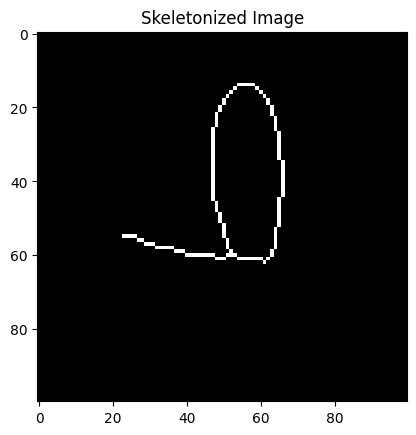

In [19]:
VISUALIZE = True
SIZE = 100
template_size = (SIZE, SIZE)
templates = [np.zeros(template_size) for _ in range(10)]
number_templates = []

# loop through each number
for num in range(10):
    # take first 90 samples for getting the averaged image (training)
    for i in range(90):
        tmp = np.zeros(template_size)
        df = dfs[num][i]
        templates[num] += rasterize_number(df, SIZE)

    # average the image and convert it to numpy array
    templates[num] /= np.sum(templates[num])
    image = np.array(templates[num])

    # scale pixels to uint range
    scaled_image = ((image - np.min(image)) / (np.max(image) - np.min(image))) * 255

    if VISUALIZE:
        plt.imshow(scaled_image, cmap='gray')
        plt.title('Scaled averaged image')
        plt.show()

    # thresholding the image and skeletonizing
    thresh = cv2.threshold(scaled_image, 127, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.flip(cv2.transpose(thresh), 1)
    skeleton = skeletonize(thresh)

    if VISUALIZE:
        plt.imshow(skeleton, cmap='gray')
        plt.title('Skeletonized Image')
        plt.show()

    # tranforming skeleton to point set
    coordinates = np.column_stack(np.where(skeleton == True))
    df = pd.DataFrame(coordinates, columns=['X', 'Y'])
    df = (df - df.mean()) / df.std()
    number_templates.append(df)

C:\Users\Matej\AppData\Local\Temp\ipykernel_19180\1191607796.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(number_templates[9]['X'],number_templates[9]['Y'] , cmap='gray')


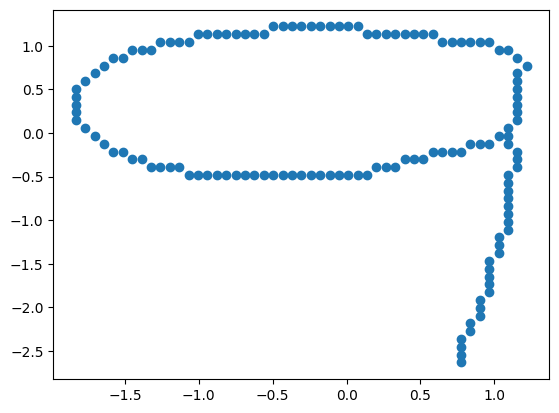

In [20]:
plt.scatter(number_templates[9]['X'],number_templates[9]['Y'] , cmap='gray')
plt.show()

random_templates = [dfs[0][9], dfs[1][86], dfs[2][10], dfs[3][8], dfs[4][11], dfs[5][4], dfs[6][2], dfs[7][9], dfs[8][14], dfs[9][0]]
# plt.scatter(random_templates[9][0], random_templates[9][1] , cmap='gray')
# plt.show()

In [21]:
def hausdorff_distance(matrix1, matrix2):
    distance_matrix = cdist(matrix1, matrix2, metric='euclidean')
    max_dist_1_to_2 = np.max(np.min(distance_matrix, axis=1))
    max_dist_2_to_1 = np.max(np.min(distance_matrix, axis=0))
    return max(max_dist_1_to_2, max_dist_2_to_1)

def sum_of_min_distances(set1, set2):
    tree = KDTree(set1)
    distances = tree.query(set2)[0]
    normalized_sum = sum(distances) / len(set2)
    return normalized_sum

# change the type of metric used here
def calculate_metric(set1, set2):
    return hausdorff_distance(set1, set2)
    return sum_of_min_distances(set1, set2)

In [22]:
DEBUG=False

# change the template set here
templates = number_templates # averaged number templates
#templates = random_templates # templates picked from the set

test_number = 0
correct = 0
all = 0
# loop through every number from 0 to 9
for df in dfs:
    # loop through specific number of samples in each number set
    for i in range(100):
        sample = df[i]
        minimum = 0
        pred = 0
        index = 0

        # find the best matching template
        for template in templates:
            metric = calculate_metric(sample.values, template.values)
            if minimum > metric or index == 0:
                pred = index
                minimum = metric
            index += 1
        all += 1

        # keep track of accuracy
        if pred == test_number:
            correct +=1
        elif DEBUG:
            print(f'Correct {test_number}, guess {pred}')

    # change the test number after going through all of the samples in a set
    test_number +=1

print(correct/all * 100)

60.4
